In [ ]:
 # Supervised learning - 


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [6]:
DATA = Path("data")
VECS = Path("vectors")
REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

SHOWS_MERGED = DATA / "shows_with_cluster_labels.parquet"   # has id, name, genres, ai_summary, cluster, cluster_label, u1, u2
EMB_ARRAY = VECS / "summaries.npy"                          # npy embeddings (normalized)
EMB_INDEX = VECS / "summaries_index.parquet"                # id + name in same order as embeddings
CAT_EMB_CACHE = VECS / "categories.npy"
OUT_PARQUET = DATA / "shows_classified.parquet"
OUT_CSV = DATA / "shows_classified.csv"

# Use the SAME model you used to embed summaries
MODEL_NAME = "all-MiniLM-L6-v2"

In [7]:
CATEGORIES = {
    "Drama": "Serious, character-driven stories and emotional conflicts.",
    "Comedy": "Lighthearted, humorous stories designed to make viewers laugh.",
    "Sci-Fi": "Futuristic technology, space, or speculative science.",
    "Fantasy": "Magic, mythical creatures, or imaginary worlds.",
    "Crime": "Police work, criminals, investigations, or legal drama.",
    "Reality": "Unscripted or competition-based programmes featuring real people.",
    "Documentary": "Nonfiction programmes educating about real events or topics.",
    "Kids": "Content primarily designed for children or families.",
    "News": "Current events, daily news, analysis, or interviews.",
    "Sports": "Live sports, analysis, or athletic competitions."
}

Loaded 200 embeddings and 485 show rows.
Aligned rows with ai_summary: 200
Loaded cached category embeddings.
Saved: C:\Users\brethm01\tv-nlp\src\data\shows_classified.parquet
Saved: C:\Users\brethm01\tv-nlp\src\data\shows_classified.csv

Sample predictions:
              name pred_category  pred_score
    Under the Dome         Crime    0.255818
Person of Interest         Crime    0.317555
            Bitten         Drama    0.243170
             Arrow         Drama    0.248701
    True Detective         Crime    0.573280
           The 100        Sci-Fi    0.347183
          Homeland         Drama    0.282113
              Glee         Drama    0.357319
           Revenge         Drama    0.287765
             Grimm       Fantasy    0.332875

Counts per predicted category:
pred_category
NaN            285
Drama           68
Crime           49
Comedy          27
Sci-Fi          22
Fantasy         20
Reality          7
Documentary      3
Kids             2
Sports           1
News      

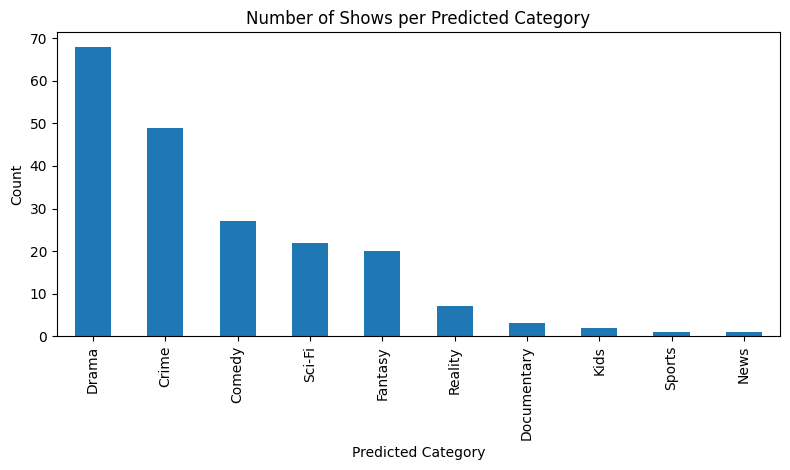

Saved plot: C:\Users\brethm01\tv-nlp\src\reports\pred_category_counts.png


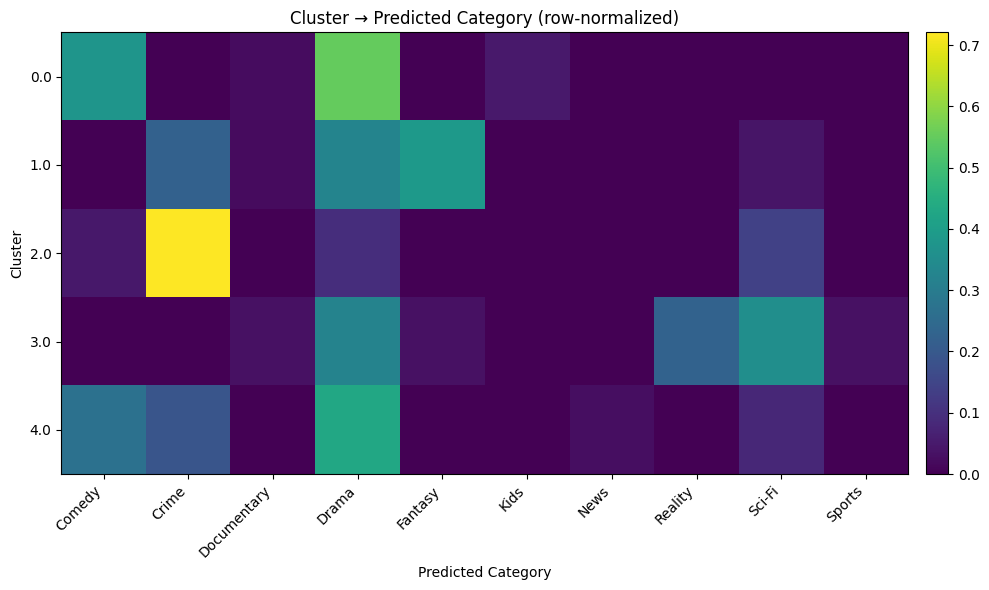

Saved plot: C:\Users\brethm01\tv-nlp\src\reports\cluster_vs_pred_category.png


In [10]:
def main():
    # ---------- Load data ----------
    shows = pd.read_parquet(SHOWS_MERGED)        # full rows incl. summaries + clusters
    X = np.load(EMB_ARRAY)                       # (n, d)
    idx = pd.read_parquet(EMB_INDEX)             # must align with X by row
    assert len(X) == len(idx), "Embeddings and index row counts differ."
    print(f"Loaded {len(X)} embeddings and {len(shows)} show rows.")

    # Align embeddings with 'shows' on id
    aligned = pd.merge(idx, shows, on="id", how="left")
    mask = aligned["ai_summary"].notna() & (aligned["ai_summary"].str.strip() != "")
    X_aligned = X[mask.values]
    aligned = aligned[mask].reset_index(drop=True)
    print(f"Aligned rows with ai_summary: {len(aligned)}")

    # ---------- Embed categories ----------
    model = SentenceTransformer(MODEL_NAME)
    cat_names = list(CATEGORIES.keys())
    cat_texts = [f"{k}: {CATEGORIES[k]}" for k in cat_names]

    if CAT_EMB_CACHE.exists():
        cat_vecs = np.load(CAT_EMB_CACHE)
        print("Loaded cached category embeddings.")
    else:
        cat_vecs = model.encode(cat_texts, convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        np.save(CAT_EMB_CACHE, cat_vecs)
        print("Saved category embeddings cache:", CAT_EMB_CACHE)

    # ---------- Zero-shot assignment via cosine (dot) ----------
    # (Your sentence-transformer embeddings were saved normalized; if not, normalize here)
    sims = X_aligned @ cat_vecs.T                   # (n, C) cosine similarity
    best_idx = sims.argmax(axis=1)
    pred = [cat_names[i] for i in best_idx]
    aligned["pred_category"] = pred
    aligned["pred_score"] = sims.max(axis=1)        # similarity of chosen category

    # ---------- Merge predictions back to full show table ----------
    shows = pd.merge(shows, aligned[["id", "pred_category", "pred_score"]], on="id", how="left")

    # ---------- Save outputs ----------
    shows.to_parquet(OUT_PARQUET, index=False)
    shows.to_csv(OUT_CSV, index=False, encoding="utf-8")
    print(f"Saved: {OUT_PARQUET.resolve()}")
    print(f"Saved: {OUT_CSV.resolve()}")

    # ---------- On-screen previews ----------
    print("\nSample predictions:")
    print(shows[["name", "pred_category", "pred_score"]].head(10).to_string(index=False))

    print("\nCounts per predicted category:")
    print(shows["pred_category"].value_counts(dropna=False).to_string())

    if "cluster" in shows.columns:
        print("\nCluster vs Predicted Category (top 100 rows shown):")
        ct = pd.crosstab(shows["cluster"], shows["pred_category"])
        print(ct.head(100).to_string())

        # ---------- Simple plot: counts by predicted category ----------
        counts = shows["pred_category"].value_counts().sort_values(ascending=False)
        plt.figure(figsize=(8, 4.8))
        counts.plot(kind="bar")
        plt.title("Number of Shows per Predicted Category")
        plt.xlabel("Predicted Category")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(REPORTS / "pred_category_counts.png", dpi=200)
        plt.show()
        print("Saved plot:", (REPORTS / "pred_category_counts.png").resolve())

        # ---------- Optional: heatmap-like image for crosstab ----------
        data = ct.values.astype(float)
        row_sums = data.sum(axis=1, keepdims=True)
        data = np.divide(data, np.where(row_sums == 0, 1, row_sums))  # row-normalize
        plt.figure(figsize=(10, 6))
        im = plt.imshow(data, aspect="auto")
        plt.colorbar(im, fraction=0.025, pad=0.02)
        plt.yticks(range(len(ct.index)), ct.index)
        plt.xticks(range(len(ct.columns)), ct.columns, rotation=45, ha="right")
        plt.title("Cluster → Predicted Category (row-normalized)")
        plt.xlabel("Predicted Category"); plt.ylabel("Cluster")
        plt.tight_layout()
        plt.savefig(REPORTS / "cluster_vs_pred_category.png", dpi=200)
        plt.show()
        print("Saved plot:", (REPORTS / "cluster_vs_pred_category.png").resolve())

if __name__ == "__main__":
    main()


 

In [16]:
# Load the parquet file saved by classify.py
result = pd.read_parquet("data/shows_classified.parquet")

# Export to CSV
result.to_csv("data/shows_classified.csv", index=False)

print("Exported full classified dataset to data/shows_classified.csv")

Exported full classified dataset to data/shows_classified.csv
